# GloVE

Let's work on implementation of GloVE.

In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import brown

## 1. Load data

In [70]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [71]:
corpus = []
sentences = brown.sents(categories="news")
corpus = [' '.join(sent).lower() for sent in sentences]
corpus = [sent.split(" ") for sent in corpus]

In [72]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [73]:
vocabs

['spirit',
 "here's",
 'undertaken',
 'geneva',
 'forestry',
 'bypass',
 'loss',
 'oldest',
 'nautilus',
 'effort',
 'convey',
 'jansen',
 'resolve',
 'nucleus',
 'bowl',
 'bicycle-auto',
 "commissioner's",
 'drive-in',
 'ebony',
 'three-month',
 'noted',
 'sit',
 'captivating',
 "miller's",
 'neusteters',
 '354',
 'weinberg',
 'frog-marched',
 'bowden',
 'bingles',
 'silhouette',
 'highest',
 'sharp',
 'faked',
 'ed',
 '$9,841,000',
 'conspicuous',
 'hammond',
 'applaud',
 '116',
 'perjury',
 '3-5',
 'yen',
 'appointed',
 'teletype',
 'suspects',
 'breuer',
 'availability',
 'noticeable',
 '357',
 'housewives',
 'yankee',
 'carruthers',
 'bases',
 'champion',
 'brisk',
 'robbery',
 'sewage',
 'signing',
 'kegham',
 '1500',
 'incredibly',
 'recovering',
 'nikita',
 'nightmare',
 '$12,192,865',
 'difficulties',
 'barr',
 'awards',
 'shrugged',
 'largest',
 'amend',
 'funeral',
 'establishment',
 'living',
 'instructor',
 'normalcy',
 'violations',
 'lenny',
 'gordin',
 '12,000',
 'belgi

In [74]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}

In [75]:
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

In [76]:
word2index

{'spirit': 0,
 "here's": 1,
 'undertaken': 2,
 'geneva': 3,
 'forestry': 4,
 'bypass': 5,
 'loss': 6,
 'oldest': 7,
 'nautilus': 8,
 'effort': 9,
 'convey': 10,
 'jansen': 11,
 'resolve': 12,
 'nucleus': 13,
 'bowl': 14,
 'bicycle-auto': 15,
 "commissioner's": 16,
 'drive-in': 17,
 'ebony': 18,
 'three-month': 19,
 'noted': 20,
 'sit': 21,
 'captivating': 22,
 "miller's": 23,
 'neusteters': 24,
 '354': 25,
 'weinberg': 26,
 'frog-marched': 27,
 'bowden': 28,
 'bingles': 29,
 'silhouette': 30,
 'highest': 31,
 'sharp': 32,
 'faked': 33,
 'ed': 34,
 '$9,841,000': 35,
 'conspicuous': 36,
 'hammond': 37,
 'applaud': 38,
 '116': 39,
 'perjury': 40,
 '3-5': 41,
 'yen': 42,
 'appointed': 43,
 'teletype': 44,
 'suspects': 45,
 'breuer': 46,
 'availability': 47,
 'noticeable': 48,
 '357': 49,
 'housewives': 50,
 'yankee': 51,
 'carruthers': 52,
 'bases': 53,
 'champion': 54,
 'brisk': 55,
 'robbery': 56,
 'sewage': 57,
 'signing': 58,
 'kegham': 59,
 '1500': 60,
 'incredibly': 61,
 'recovering'

In [77]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'bypass'

In [78]:
vocabs

['spirit',
 "here's",
 'undertaken',
 'geneva',
 'forestry',
 'bypass',
 'loss',
 'oldest',
 'nautilus',
 'effort',
 'convey',
 'jansen',
 'resolve',
 'nucleus',
 'bowl',
 'bicycle-auto',
 "commissioner's",
 'drive-in',
 'ebony',
 'three-month',
 'noted',
 'sit',
 'captivating',
 "miller's",
 'neusteters',
 '354',
 'weinberg',
 'frog-marched',
 'bowden',
 'bingles',
 'silhouette',
 'highest',
 'sharp',
 'faked',
 'ed',
 '$9,841,000',
 'conspicuous',
 'hammond',
 'applaud',
 '116',
 'perjury',
 '3-5',
 'yen',
 'appointed',
 'teletype',
 'suspects',
 'breuer',
 'availability',
 'noticeable',
 '357',
 'housewives',
 'yankee',
 'carruthers',
 'bases',
 'champion',
 'brisk',
 'robbery',
 'sewage',
 'signing',
 'kegham',
 '1500',
 'incredibly',
 'recovering',
 'nikita',
 'nightmare',
 '$12,192,865',
 'difficulties',
 'barr',
 'awards',
 'shrugged',
 'largest',
 'amend',
 'funeral',
 'establishment',
 'living',
 'instructor',
 'normalcy',
 'violations',
 'lenny',
 'gordin',
 '12,000',
 'belgi

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [79]:
from collections import Counter

X_i = Counter(flatten(corpus))
X_i

Counter({'the': 6386,
         ',': 5188,
         '.': 4030,
         'of': 2861,
         'and': 2186,
         'to': 2144,
         'a': 2130,
         'in': 2020,
         'for': 969,
         'that': 829,
         'is': 733,
         '``': 732,
         'was': 717,
         "''": 702,
         'on': 691,
         'he': 642,
         'at': 636,
         'with': 567,
         'be': 526,
         'as': 517,
         'by': 504,
         'it': 478,
         'his': 428,
         'said': 406,
         'will': 389,
         'from': 353,
         'are': 330,
         'this': 320,
         ';': 314,
         'an': 311,
         'has': 301,
         '--': 300,
         'but': 283,
         'had': 281,
         'who': 268,
         'they': 267,
         'have': 265,
         'not': 257,
         'mrs.': 253,
         'were': 252,
         'would': 246,
         'which': 245,
         'new': 241,
         'their': 231,
         'one': 213,
         'been': 212,
         'there': 189,
         

In [80]:
def compute_skipgrams(corpus, window_size=2):
    skip_grams = []
    n = len(corpus)
    for i in range(n):
        center = corpus[i]
        start = max(0, i - window_size)
        end = min(n - 1, i + window_size)
        for j in range(start, end + 1):
            if j == i:
                continue
            skip_grams.append((center, corpus[j]))
    return skip_grams

# keep current behavior; adjust window_size to use a larger context
skip_grams = compute_skipgrams(flatten(corpus), window_size=2)

skip_grams

[('the', 'fulton'),
 ('the', 'county'),
 ('fulton', 'the'),
 ('fulton', 'county'),
 ('fulton', 'grand'),
 ('county', 'the'),
 ('county', 'fulton'),
 ('county', 'grand'),
 ('county', 'jury'),
 ('grand', 'fulton'),
 ('grand', 'county'),
 ('grand', 'jury'),
 ('grand', 'said'),
 ('jury', 'county'),
 ('jury', 'grand'),
 ('jury', 'said'),
 ('jury', 'friday'),
 ('said', 'grand'),
 ('said', 'jury'),
 ('said', 'friday'),
 ('said', 'an'),
 ('friday', 'jury'),
 ('friday', 'said'),
 ('friday', 'an'),
 ('friday', 'investigation'),
 ('an', 'said'),
 ('an', 'friday'),
 ('an', 'investigation'),
 ('an', 'of'),
 ('investigation', 'friday'),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('investigation', "atlanta's"),
 ('of', 'an'),
 ('of', 'investigation'),
 ('of', "atlanta's"),
 ('of', 'recent'),
 ("atlanta's", 'investigation'),
 ("atlanta's", 'of'),
 ("atlanta's", 'recent'),
 ("atlanta's", 'primary'),
 ('recent', 'of'),
 ('recent', "atlanta's"),
 ('recent', 'primary'),
 ('recent', 'election'),


In [81]:
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('of', 'the'): 1545,
         ('the', 'of'): 1545,
         ('.', 'the'): 1200,
         ('the', '.'): 1200,
         ('the', ','): 942,
         (',', 'the'): 942,
         (',', ','): 838,
         ('the', 'in'): 724,
         ('in', 'the'): 724,
         (',', 'and'): 632,
         ('and', ','): 632,
         ('to', 'the'): 606,
         ('the', 'to'): 606,
         ('of', ','): 382,
         (',', 'of'): 382,
         ('the', 'and'): 372,
         ('and', 'the'): 372,
         ('a', 'of'): 371,
         ('of', 'a'): 371,
         ('a', ','): 339,
         (',', 'a'): 339,
         (';', ';'): 314,
         (',', 'in'): 310,
         ('in', ','): 310,
         ("''", '.'): 301,
         ('.', "''"): 301,
         ('for', 'the'): 295,
         ('the', 'for'): 295,
         ('on', 'the'): 295,
         ('the', 'on'): 295,
         ('in', '.'): 272,
         ('.', 'in'): 272,
         ('.', ','): 264,
         (',', '.'): 264,
         ('said', ','): 256,
         (',', 'said'

### Weighting function

GloVe includes a weighting function to scale down too frequent words.


In [82]:
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [83]:
# Build only observed co-occurrences to avoid O(|V|^2) memory
X_ik = {pair: co + 1 for pair, co in X_ik_skipgrams.items()}  # Laplace smoothing

# Precompute weightings only for observed pairs
x_max = 100
alpha = 0.75
weighting_dic = {
    pair: ((x_ij / x_max) ** alpha if x_ij < x_max else 1.0)
    for pair, x_ij in X_ik.items()
}


## 3. Prepare train data

In [84]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [85]:
batch_size = 8 #2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [86]:
x

array([[ 8271],
       [ 2102],
       [ 6127],
       [12343],
       [13068],
       [ 8217],
       [ 4826],
       [11905]])

In [87]:
y

array([[12354],
       [11717],
       [10401],
       [ 2171],
       [ 5321],
       [ 3477],
       [ 8217],
       [12983]])

In [88]:
cooc

array([[1.09861229],
       [0.69314718],
       [0.69314718],
       [1.38629436],
       [0.69314718],
       [1.60943791],
       [1.09861229],
       [0.69314718]])

In [89]:
weighting

array([[0.07208434],
       [0.05318296],
       [0.05318296],
       [0.08944272],
       [0.05318296],
       [0.10573713],
       [0.07208434],
       [0.05318296]])

## 4. Model


In [90]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [91]:
#test our system
voc_size = len(vocabs)
emb_size = 10
model = Glove(voc_size, emb_size)

In [92]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [93]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [94]:
loss

tensor(5.8214, grad_fn=<SumBackward0>)

## 5. Training

In [95]:
batch_size     = 8 # mini-batch size
embedding_size = 10 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [97]:
import time

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    # forward and average loss 
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    loss = loss / input_batch.size(0)

    # inline logging for training loss and time
    print(f"Epoch {epoch + 1}/{num_epochs} - loss: {loss.detach().item():.6f} - time: {time.time() - start:.2f}s")
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch 1/1000 - loss: 33.470757 - time: 0.06s
Epoch 2/1000 - loss: 2.118985 - time: 0.06s
Epoch 3/1000 - loss: 6.579128 - time: 0.06s
Epoch 4/1000 - loss: 2.118161 - time: 0.06s
Epoch 5/1000 - loss: 0.817853 - time: 0.06s
Epoch 6/1000 - loss: 19.611141 - time: 0.06s
Epoch 7/1000 - loss: 3.701445 - time: 0.06s
Epoch 8/1000 - loss: 8.685634 - time: 0.06s
Epoch 9/1000 - loss: 13.398614 - time: 0.06s
Epoch 10/1000 - loss: 9.990096 - time: 0.06s
Epoch 11/1000 - loss: 6.823460 - time: 0.06s
Epoch 12/1000 - loss: 1.272045 - time: 0.06s
Epoch 13/1000 - loss: 2.994634 - time: 0.06s
Epoch 14/1000 - loss: 2.239316 - time: 0.06s
Epoch 15/1000 - loss: 13.573826 - time: 0.06s
Epoch 16/1000 - loss: 0.892105 - time: 0.06s
Epoch 17/1000 - loss: 4.330281 - time: 0.06s
Epoch 18/1000 - loss: 1.603690 - time: 0.06s
Epoch 19/1000 - loss: 1.295099 - time: 0.06s
Epoch 20/1000 - loss: 0.585398 - time: 0.06s
Epoch 21/1000 - loss: 5.993653 - time: 0.06s
Epoch 22/1000 - loss: 5.106398 - time: 0.06s
Epoch 23/1000 -

## 6. Plotting the embeddings

In [98]:
#list of vocabs
vocabs[:10]

['spirit',
 "here's",
 'undertaken',
 'geneva',
 'forestry',
 'bypass',
 'loss',
 'oldest',
 'nautilus',
 'effort']

In [99]:
word = vocabs[0]

In [100]:
#numericalization
id = word2index[word]
id

0

In [101]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [102]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 0.0775,  0.4859, -1.4487,  2.8654,  1.2979, -1.2770,  0.9442, -0.4152,
          -2.7435,  0.3956]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.1610,  0.8360, -1.1707, -0.2463, -0.6271, -0.2682, -0.0763, -0.9487,
          -0.2816, -0.4903]], grad_fn=<EmbeddingBackward0>))

In [103]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[-0.5417,  0.6610, -1.3097,  1.3095,  0.3354, -0.7726,  0.4339, -0.6819,
         -1.5126, -0.0473]], grad_fn=<DivBackward0>)

In [104]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

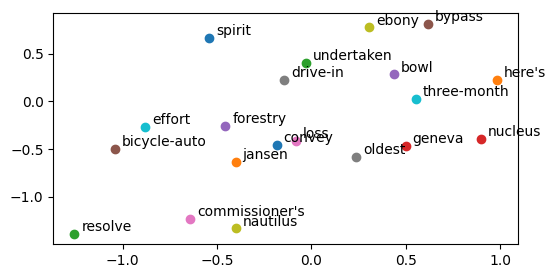

In [105]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [106]:
vocabs

['spirit',
 "here's",
 'undertaken',
 'geneva',
 'forestry',
 'bypass',
 'loss',
 'oldest',
 'nautilus',
 'effort',
 'convey',
 'jansen',
 'resolve',
 'nucleus',
 'bowl',
 'bicycle-auto',
 "commissioner's",
 'drive-in',
 'ebony',
 'three-month',
 'noted',
 'sit',
 'captivating',
 "miller's",
 'neusteters',
 '354',
 'weinberg',
 'frog-marched',
 'bowden',
 'bingles',
 'silhouette',
 'highest',
 'sharp',
 'faked',
 'ed',
 '$9,841,000',
 'conspicuous',
 'hammond',
 'applaud',
 '116',
 'perjury',
 '3-5',
 'yen',
 'appointed',
 'teletype',
 'suspects',
 'breuer',
 'availability',
 'noticeable',
 '357',
 'housewives',
 'yankee',
 'carruthers',
 'bases',
 'champion',
 'brisk',
 'robbery',
 'sewage',
 'signing',
 'kegham',
 '1500',
 'incredibly',
 'recovering',
 'nikita',
 'nightmare',
 '$12,192,865',
 'difficulties',
 'barr',
 'awards',
 'shrugged',
 'largest',
 'amend',
 'funeral',
 'establishment',
 'living',
 'instructor',
 'normalcy',
 'violations',
 'lenny',
 'gordin',
 '12,000',
 'belgi

In [107]:
jobs          = get_embed('jobs')
vacancy        = get_embed('vacancy')
death       = get_embed('death')

In [108]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"vacancy vs. jobs: ",        cos_sim(vacancy, jobs))
print(f"vacancy vs. death: ",       cos_sim(vacancy, death))
print(f"vacancy vs. vacancy: ",          cos_sim(vacancy, vacancy))

vacancy vs. jobs:  0.8262195066939214
vacancy vs. death:  -0.2952529627773184
vacancy vs. vacancy:  1.0


In [109]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"vacancy vs. jobs: ",        cos_sim(vacancy, jobs))
print(f"vacancy vs. death: ",       cos_sim(vacancy, death))
print(f"vacancy vs. vacancy: ",          cos_sim(vacancy, vacancy))

vacancy vs. jobs:  0.8262195066939214
vacancy vs. death:  -0.2952529627773184
vacancy vs. vacancy:  1.0


In [110]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Step 1: build final embedding matrix
W = (model.center_embedding.weight.detach().cpu().numpy() +
     model.outside_embedding.weight.detach().cpu().numpy()) / 2

# Normalize embeddings for fast cosine similarity
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)



def get_vector(word):
    if word not in word2index:
        return None
    return W_norm[word2index[word]] 


In [111]:
print(W.shape)
print(get_vector("vacancy"))
print(len(get_vector("vacancy")))


(13113, 10)
[-0.06836421 -0.563455   -0.21909861  0.37455904 -0.17898801 -0.2201623
 -0.09827104 -0.43607172  0.375272    0.26152083]
10


In [112]:
index2word = {idx: word for word, idx in word2index.items()}
def predict_analogy(a, b, c, W_norm, word2index, index2word):
    if a not in word2index or b not in word2index or c not in word2index:
        return None

    va = W_norm[word2index[a]]
    vb = W_norm[word2index[b]]
    vc = W_norm[word2index[c]]

    # Vector arithmetic: b - a + c
    target = vb - va + vc
    target = target / np.linalg.norm(target)

    # Cosine similarity with ALL words at once
    similarities = np.dot(W_norm, target)

    # Exclude input words
    for w in (a, b, c):
        similarities[word2index[w]] = -1

    best_index = np.argmax(similarities)
    return index2word[best_index]



In [113]:
predict_analogy("vacancy", "death", "jobs", W, word2index, index2word)


'ailerons'

In [114]:

def evaluate_analogies(file_path, W_norm, word2index, index2word):
    total = 0
    correct = 0

    with open(file_path, "r") as f:
        for line in f:
            words = line.strip().split()
            if len(words) != 4:
                continue

            a, b, c, d = words
            prediction = predict_analogy(
                a, b, c, W_norm, word2index, index2word
            )

            if prediction is None:
                continue

            total += 1
            if prediction == d:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total


In [115]:
semantic_acc, sem_correct, sem_total = evaluate_analogies(
    "country-capital.txt",
    W,
    word2index,
    index2word
)


In [116]:
syntactic_acc, syn_correct, syn_total = evaluate_analogies(
    "past-tense.txt",
    W,
    word2index,
    index2word
)

print(f"Semantic accuracy (capital-common-countries): {semantic_acc:.4f} ({sem_correct}/{sem_total})")
print(f"Syntactic accuracy (past-tense): {syntactic_acc:.4f} ({syn_correct}/{syn_total})")


Semantic accuracy (capital-common-countries): 0.0000 (0/0)
Syntactic accuracy (past-tense): 0.0000 (0/648)


In [117]:
import pandas as pd
similarity_df = pd.read_csv("combined.csv")
similarity_df.head()

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [118]:
model_scores = []
human_scores = []
skipped = 0

for _, row in similarity_df.iterrows():
    w1 = row["Word 1"]
    w2 = row["Word 2"]
    human_score = row["Human (mean)"]

    if w1 not in word2index or w2 not in word2index:
        skipped += 1
        continue

    v1 = W_norm[word2index[w1]]
    v2 = W_norm[word2index[w2]]

    model_sim = np.dot(v1, v2)  # cosine similarity

    model_scores.append(model_sim)
    human_scores.append(human_score)

print(f"Used pairs: {len(model_scores)}")
print(f"Skipped OOV pairs: {skipped}")


Used pairs: 197
Skipped OOV pairs: 156


In [119]:

from scipy.stats import spearmanr

correlation, p_value = spearmanr(model_scores, human_scores)

print(f"Spearman correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")


Spearman correlation: 0.0519
P-value: 4.6884e-01


In [120]:
print("Example comparisons:")
for i in range(5):
    print(
        similarity_df.iloc[i, 0],
        similarity_df.iloc[i, 1],
        "Human:", human_scores[i],
        "Model:", round(model_scores[i], 3)
    )



Example comparisons:
love sex Human: 6.77 Model: 0.7
tiger cat Human: 7.46 Model: -0.237
tiger tiger Human: 5.77 Model: 0.508
book paper Human: 6.31 Model: 0.155
computer keyboard Human: 7.5 Model: -0.231


In [121]:
start_time = time.time()
for i in range(5, 10):
    print(
        similarity_df.iloc[i, 0],
        similarity_df.iloc[i, 1],
        "Human:", human_scores[i],
        "Model:", round(model_scores[i], 3)
    )
end_time = time.time()
print(f"Time taken for second batch: {end_time - start_time:.4f} seconds")

computer internet Human: 6.77 Model: 0.215
plane car Human: 6.19 Model: 0.624
train car Human: 7.0 Model: -0.073
telephone communication Human: 6.62 Model: 0.212
television radio Human: 6.81 Model: 0.324
Time taken for second batch: 0.0000 seconds


## Summary: GloVe Implementation from Scratch

This notebook provides a step-by-step implementation of the **Global Vectors for Word Representation (GloVe)** model using PyTorch, trained on the NLTK Reuters corpus.

### Key Implementation Phases:
* **Data Preparation**:
    * **Corpus Processing**: Loaded and tokenized the `reuters` dataset, filtering for alphabetic characters.
    * **Co-occurrence Matrix**: Generated skip-grams and constructed a global co-occurrence matrix ($X$) to capture word-word relationships within a context window.
    * **Weighting Function**: Implemented the GloVe weighting function $f(X_{ij}) = (x_{ij}/x_{max})^\alpha$ to scale down the influence of extremely frequent word pairs.
* **Model Architecture**:
    * Defined a custom `Glove` class featuring center and outside word embeddings along with their respective biases.
    * The loss function was designed to minimize the squared difference between the dot product of vectors (plus biases) and the log of their co-occurrence counts, weighted by the frequency function.
* **Training**:
    * Optimized the model using the **Adam** optimizer over multiple epochs.
    * Implemented a `random_batch` function to efficiently sample observed co-occurrences for training.
* **Evaluation**:
    * **Word Similarity**: Tested the quality of learned embeddings using the **WordSim-353** dataset.
    * **Spearman Correlation**: Calculated the correlation between the model's cosine similarity scores and human-judged similarity scores to measure semantic accuracy.
